In [6]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import (
    HistGradientBoostingClassifier,
    GradientBoostingClassifier
)

from sklearn.linear_model import (SGDClassifier)

from sklearn.model_selection import cross_val_score, TimeSeriesSplit

from xgboost import XGBRFClassifier

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [7]:
processed = '../data/processed'
main_data = pd.read_pickle(Path(processed) / 'main_data.pkl')

In [8]:
main_data = main_data[(main_data.b_prev_G > 50)]

x_vars = [
    'spot', 'home', 'b_pred_HPPA', 'p_pred_HPAB', 'park_factor', 'year',
    'BAT_HAND', 'PIT_HAND', 'b_avg_win', 'own_p_pred_HPAB',
    'p_team_HPG', 'p_team_avg_game_score', 'rating_rating_pre',
    'rating_rating_prob', 'rating_pitcher_rgs',
    'rating_own_rating_pre', 'rating_own_pitcher_rgs'
]
y_var = ['Win']
vars = x_vars + y_var

main_data = main_data.loc[:, vars]
main_data = main_data.dropna()

train = main_data[(main_data.year < 2000) & (main_data.year >= 1960)]
test = main_data[(main_data.year >= 2000)]

train_x = train[x_vars]
train_y = train['Win'].astype('int')
test_x = test[x_vars]
test_y = test['Win'].astype('int')

In [9]:
preprocessor =  ColumnTransformer(
    [('spot', 'passthrough', x_vars)],
    remainder='drop'
)

sgd = SGDClassifier(
    loss='log',
    penalty='l1',
    random_state=0,
    max_iter = 1000,
    alpha = .0001
)

clf = XGBRFClassifier(
    verbosity = 1,
    random_state = 0,
    n_estimators = 300,
    use_label_encoder=False,
    eval_metric='auc',
    colsample_bynode=0.3,
    subsample = .8,
)

fitted_model = Pipeline([
    ('select', preprocessor),
    ('poly', PolynomialFeatures(2, interaction_only=True)),
    ('scale', StandardScaler()),
    ('feature_selection', SelectFromModel(sgd)),
    ('clf', clf),
])

In [10]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
results = cross_val_score(fitted_model, train, train['Win'].astype('int'), cv=cv, n_jobs=-1, scoring='roc_auc')
print(results)
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

[0.56715459 0.56679069 0.56739892 0.56710981 0.56678178 0.56850315
 0.56805495 0.56718827 0.56541969 0.56659594 0.56687443 0.56929063
 0.56770599 0.56752557 0.56534939]
Accuracy: 56.718% (0.099%)


In [11]:
fitted_model.fit(train, train['Win'].astype('int'))

Pipeline(steps=[('select',
                 ColumnTransformer(transformers=[('spot', 'passthrough',
                                                  ['spot', 'home',
                                                   'b_pred_HPPA', 'p_pred_HPAB',
                                                   'park_factor', 'year',
                                                   'BAT_HAND', 'PIT_HAND',
                                                   'b_avg_win',
                                                   'own_p_pred_HPAB',
                                                   'p_team_HPG',
                                                   'p_team_avg_game_score',
                                                   'rating_rating_pre',
                                                   'rating_rating_prob',
                                                   'rating_pitcher_rgs',
                                                   'rating_own_rating_pre',
                                  

In [12]:
y_pred = fitted_model.predict_proba(test)[:, 1]
y_true = test['Win'].astype('int')
print(roc_auc_score(y_true, y_pred))

0.5647414238054803


In [13]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=1)

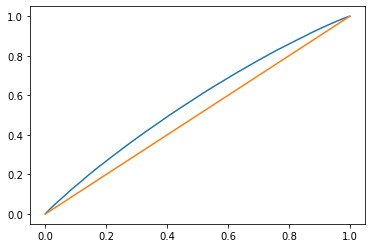

In [14]:
plt.plot(fpr, tpr, tpr, tpr)

In [15]:
mask = fitted_model.named_steps['feature_selection'].get_support()

new_features = []
for bool, feature in zip(mask, x_vars):
    if bool:
        new_features.append(feature)
  
import numpy as np
perc = round(np.sqrt(len(new_features)) / len(new_features), 2)
print(str(perc*100) + '%')

100.0%


In [16]:
fitted_model.named_steps['feature_selection'].get_support().sum()

14